# Building A Linear Regression with PySpark and MLlib
reference: https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a

In [1]:
!pip install kaggle >/dev/null
!pip install mleap > /dev/null

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Install MLeap:
spark-shell --packages ml.combust.mleap:mleap-spark_2.11:0.10.0

In [2]:
import io, os
import zipfile
import pandas as pd
import six
try:
  from pathlib import Path
except ImportError:
  from pathlib2 import Path  # python 2 backport

In [3]:
# Write kaggle.json to ~/.kaggle/
filename = "/root/.kaggle/kaggle.json"

Path(os.path.dirname(filename)).mkdir(exist_ok=True)
!sudo gsutil cp gs://ontario-2018-dataproc/notebooks/kaggle.json {filename}
os.chmod(filename, 600)

Copying gs://ontario-2018-dataproc/notebooks/kaggle.json...
/ [1 files][   63.0 B/   63.0 B]                                                
Operation completed over 1 objects/63.0 B.                                       


## Boston Housing Dataset
reference: https://www.kaggle.com/c/boston-housing/data

In [4]:
dataset = 'boston-housing'

In [5]:
folder = '/home/datalab/datasets/'+dataset
Path(os.path.dirname(folder)).mkdir(exist_ok=True)
if not os.path.isdir(folder):
  os.mkdir(folder)
os.chdir(folder)
os.system('kaggle competitions download -c '+dataset)
for file in os.listdir(folder):
  filename, file_extension = os.path.splitext(file)
  if file_extension == '.zip':
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

In [6]:
training_dataset=os.path.abspath('train.csv')
print(training_dataset)

/home/datalab/datasets/boston-housing/train.csv


In [7]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sc= SparkContext()
sqlContext = SQLContext(sc)

In [8]:
!hdfs dfs -mkdir -p /hdfs/mydataproc-m/user/root/datasets
!hadoop fs -put {training_dataset} /hdfs/mydataproc-m/user/root/datasets
!hadoop fs -ls /hdfs/mydataproc-m/user/root/datasets

18/11/05 20:07:09 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: hadoop2-1.9.8
18/11/05 20:07:11 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: hadoop2-1.9.8
put: `/hdfs/mydataproc-m/user/root/datasets/train.csv': File exists
18/11/05 20:07:13 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: hadoop2-1.9.8
Found 1 items
-rw-r--r--   2 root hadoop      24128 2018-11-05 19:35 /hdfs/mydataproc-m/user/root/datasets/train.csv


In [9]:
house_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('hdfs://mydataproc-m/user/root/datasets/train.csv')
house_df.take(1)

AnalysisException: u'Path does not exist: hdfs://mydataproc-m/user/root/datasets/train.csv;'

In [10]:
house_pddf=pd.read_csv(training_dataset)
house_pddf.head()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [11]:
house_df=sqlContext.createDataFrame(house_pddf)
house_df.take(1)

[Row(ID=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.5379999999999999, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

In [12]:
house_df.cache()
house_df.printSchema()

root
 |-- ID: long (nullable = true)
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: long (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: long (nullable = true)
 |-- tax: long (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [13]:
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
ID,333,250.95195195195194,147.8594378018597,1,506
crim,333,3.3603414714714708,7.3522718367811075,0.00632,73.5341
zn,333,10.68918918918919,22.674761796618213,0.0,100.0
indus,333,11.293483483483486,6.99812310447731,0.74,27.74
chas,333,0.06006006006006006,0.23795564281644835,0,1
nox,333,0.5571441441441441,0.1149545083028929,0.385,0.871
rm,333,6.2656186186186185,0.7039515757334474,3.5610000000000004,8.725
age,333,68.22642642642643,28.13334360562339,6.0,100.0
dis,333,3.709933633633634,1.9811230514407,1.1296,10.7103


In [14]:
numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [15]:
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to MV for ", i, house_df.stat.corr('medv',i))

('Correlation to MV for ', 'ID', -0.22169418651611605)
('Correlation to MV for ', 'crim', -0.4074543235732591)
('Correlation to MV for ', 'zn', 0.3448419756966427)
('Correlation to MV for ', 'indus', -0.47393197065920367)
('Correlation to MV for ', 'chas', 0.20438998859918708)
('Correlation to MV for ', 'nox', -0.41305415199207784)
('Correlation to MV for ', 'rm', 0.6895980892872151)
('Correlation to MV for ', 'age', -0.3588882740619018)
('Correlation to MV for ', 'dis', 0.24942226829396372)
('Correlation to MV for ', 'rad', -0.3522508242456334)
('Correlation to MV for ', 'tax', -0.4480776944007038)
('Correlation to MV for ', 'ptratio', -0.4813759555249174)
('Correlation to MV for ', 'black', 0.33665955532155734)
('Correlation to MV for ', 'lstat', -0.7386000348786338)
('Correlation to MV for ', 'medv', 1.0)


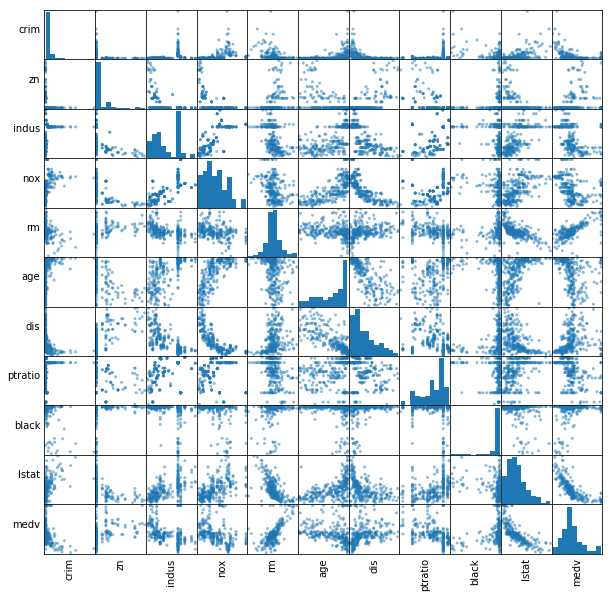

In [16]:
numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [17]:
house_df.columns

['ID',
 'crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'black',
 'lstat',
 'medv']

In [18]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df = vhouse_df.select(['features', 'medv'])
vhouse_df.show(3)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.03236999999999...|33.4|
+--------------------+----+
only showing top 3 rows



In [19]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [20]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.02727713523991685,-0.06612704697157448,3.1820574654099567,-0.9384231524645371,3.44600037855623,-0.005374147253468032,-0.7310138172115427,0.0036671604534282403,0.0,-0.5531753758500908,0.011475324745015957,-0.5973580177921394]
Intercept: 18.2979614985


In [21]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 4.904041
r2: 0.701745


In [22]:
train_df.describe().show()

+-------+------------------+
|summary|              medv|
+-------+------------------+
|  count|               228|
|   mean|22.567982456140342|
| stddev| 8.999421487018623|
|    min|               5.6|
|    max|              50.0|
+-------+------------------+



In [23]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","medv","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="medv",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|30.568333746579384|24.0|[0.00632,18.0,2.3...|
|31.551915744712264|31.6|[0.01432,100.0,1....|
|26.815732246289052|24.7|[0.02055,85.0,0.7...|
| 30.25525229726275|30.8|[0.02763000000000...|
|24.812168148873408|22.9|[0.03551,25.0,4.8...|
+------------------+----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.702428


In [24]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 5.19553


In [25]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.49999999999999956, 0.4321867076235565, 0.2470334324278745, 0.2261607885026924, 0.19638733639330713, 0.19076789151457188, 0.18886960889351273, 0.18759790042551927, 0.1873578448054453, 0.18732260597896505, 0.18728763952865496]
+--------------------+
|           residuals|
+--------------------+
|  4.8142978658840185|
|  0.4694172782095407|
|   7.862100090422764|
| -3.1175690382627224|
| -1.9850130661046599|
|  3.7996737407523575|
|  1.7364656484296646|
|  -6.003816001032128|
|-0.21083743701301927|
| -2.9471081169504885|
|  -4.971717493045006|
| -2.5728887257109747|
| -3.9092999680427027|
|-0.49847131769871567|
| -0.5296582628257838|
|   1.031980308461776|
|   -1.77344970384598|
|   -6.62450503716979|
| -0.5118676455318862|
|   2.417114293476658|
+--------------------+
only showing top 20 rows



In [26]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","medv","features").show()

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|30.568333746579384|24.0|[0.00632,18.0,2.3...|
|31.551915744712264|31.6|[0.01432,100.0,1....|
|26.815732246289052|24.7|[0.02055,85.0,0.7...|
| 30.25525229726275|30.8|[0.02763000000000...|
|24.812168148873408|22.9|[0.03551,25.0,4.8...|
|24.283173773893097|20.6|[0.04294,28.0,15....|
|27.259450963796567|26.6|[0.05735,0.0,4.49...|
| 28.66700080337136|36.2|[0.06905,0.0,2.18...|
| 25.19086697064928|24.2|[0.08826,0.0,10.8...|
|22.125759429781713|20.0|[0.10153,0.0,12.8...|
|23.770390348836514|21.4|[0.11504,0.0,2.89...|
|21.574153413749166|18.9|[0.11747,12.5,7.8...|
|22.810133378212562|21.2|[0.12269000000000...|
| 20.83726181158101|20.4|[0.13117,0.0,8.56...|
|24.965970512132085|18.5|[0.14231,0.0,10.0...|
|18.171944836082258|18.7|[0.14932,25.0,5.1...|
| 23.96861270311245|19.2|[0.15098,0.0,10.0...|
|24.035192859522134|23.4|[0.19539,0.0,10.8...|
|16.928232964